### Single Object Detection: IGrand Challenge

- Exploratory data analysis
- Data transformation for object detection
- Creating custom datasets
- Creating the model
- Defining the loss, optimizer, and IOU metric
- Training and evaluation of the model
- Deploying the model

In [1]:
import pandas as pd
import os
import torch

path2data = "./"

path2labels = "./Fovea_location.xlsx"


In [2]:
labels_df = pd.read_excel(path2labels, index_col='ID')

In [3]:
labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


In [4]:
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


<AxesSubplot:ylabel='Fovea_Y'>

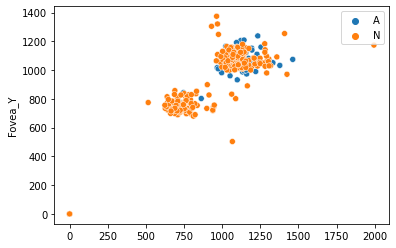

In [5]:
import seaborn as sns
%matplotlib inline

AorN = [inm[0] for inm in labels_df.imgName]
sns.scatterplot(x = labels_df.Fovea_X.values, y = labels_df.Fovea_Y, hue = AorN)

In [6]:
import collections
counter = collections.Counter(AorN)
print(counter)

Counter({'N': 311, 'A': 89})


In [7]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


In [8]:
plt.figure(figsize = (15,15))
plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
nrows, ncols = 2,3
img_name = labels_df["imgName"]
ids = labels_df.index
rndIds = np.random.choice(ids, nrows*ncols)
print(rndIds)

[358 289  27 263  80 196]


<Figure size 1080x1080 with 0 Axes>

In [9]:
def load_img_label(labels_df, id_):
    imgName = labels_df["imgName"]
    if imgName[id_][0] == 'A':
        prefix = "AMD"
    else:
        prefix = "Non-AMD"
    path = os.path.join(path2data, "Training400", prefix, imgName[id_])
    
    img = Image.open(path)
    x = labels_df["Fovea_X"][id_]
    y = labels_df["Fovea_Y"][id_]
    label = (x,y)
    
    return img, label


In [10]:
def show_img_label(img,label, w_h = (50,50), thickness = 2):
    w,h = w_h
    cx, cy = label
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-(w/2), cy-(h/2)), (cx+(w/2), cy+(h/2))), outline = "green", width = thickness)
    plt.imshow(np.asarray(img))
    


(2124, 2056) (1082.26550234603, 1001.14806046747)
(1444, 1444) (515.419867495539, 774.366863389865)
(2124, 2056) (1051.99061073268, 960.20905491837)
(1444, 1444) (943.758877052111, 742.419608608355)
(2124, 2056) (1191.74263818868, 1047.72869256247)
(1444, 1444) (654.187439604162, 745.031152761605)


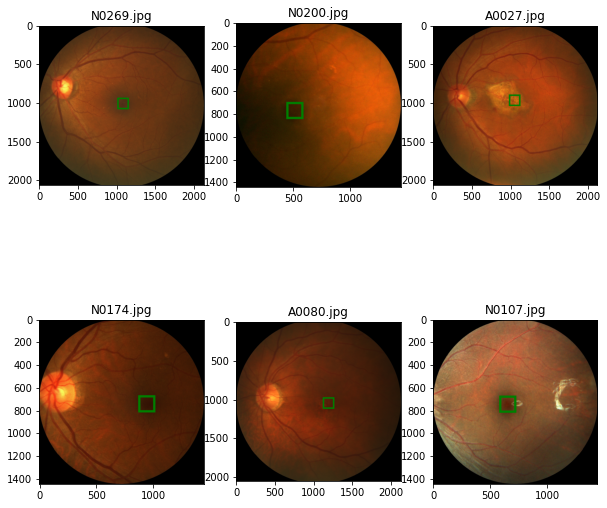

In [11]:
plt.figure(figsize=(10,10))
for i, id_ in enumerate(rndIds):
    img, labels = load_img_label(labels_df, id_)
    print(img.size, labels)
    plt.subplot(nrows, ncols, i+1)
    show_img_label(img, labels, w_h = (150,150), thickness=20)
    img_name = labels_df['imgName']
    plt.title(img_name[id_])

In [12]:
h_list, w_list = [], []

for i in labels_df.imgName:
    if i[0] == 'A':
        prefix = 'AMD'
    else:
        prefix = 'Non-AMD'
    path = os.path.join(path2data, "Training400", prefix, i)
    
    img = Image.open(path)
    h,w = img.size
    h_list.append(h)
    w_list.append(w)

Text(0.5, 1.0, 'Height')

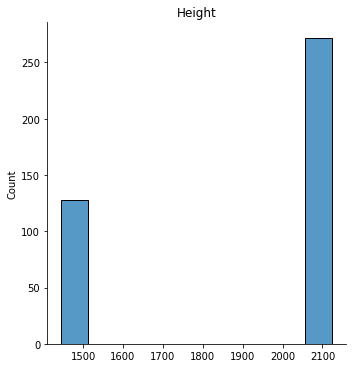

In [13]:
sns.displot(h_list)
plt.title('Height')

Text(0.5, 1.0, 'Width')

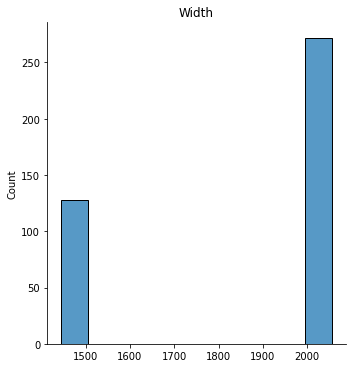

In [14]:
sns.displot(w_list)
plt.title('Width')

## Data Transformation

In [15]:
import torchvision.transforms.functional as TF

def resize_img_label(image, label = (0.0,0.0), target_size = (256,256)):
    w_orig, h_orig = image.size
    w_target, h_target = target_size
    cx,cy = label
    image_new = TF.resize(image,target_size)
    label_new = cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new, label_new

(1444, 1444) (654.187439604162, 745.031152761605)
(256, 256) (115.97782862788468, 132.08308525413494)


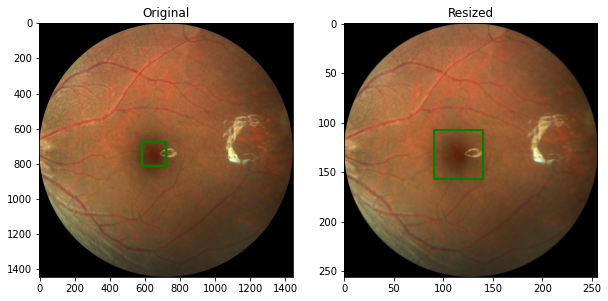

In [16]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img,label, w_h=(150,150), thickness=15)


plt.subplot(1,2,2)
plt.title('Resized')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)

In [17]:
def random_vflip(image, label):
    w,h = image.size
    x,y = label
    
    image = TF.vflip(image)
    label = x, h-y
    
    return image, label


(1444, 1444) (654.187439604162, 745.031152761605)
(256, 256) (115.97782862788468, 132.08308525413494)


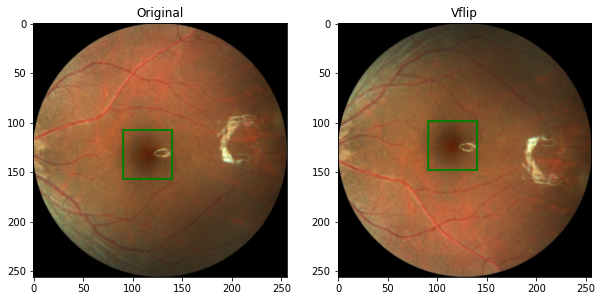

In [18]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)


plt.subplot(1,2,2)
plt.title('Vflip')
img_v, label_v = random_vflip(img_r, label_r)
show_img_label(img_v,label_v, w_h=(50,50), thickness=2)

In [19]:
def random_hflip(image, label):
    w,h = image.size
    x,y = label
    
    image = TF.hflip(image)
    label = w-x, y
    
    return image, label


(1444, 1444) (654.187439604162, 745.031152761605)
(256, 256) (115.97782862788468, 132.08308525413494)


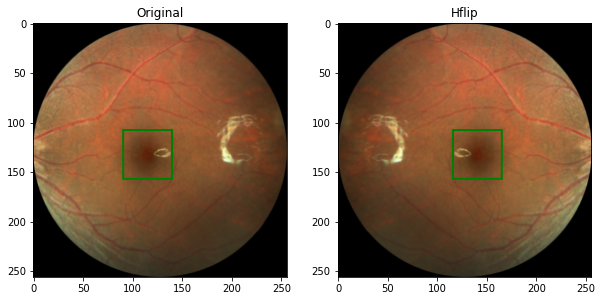

In [20]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)


plt.subplot(1,2,2)
plt.title('Hflip')
img_h, label_h = random_hflip(img_r, label_r)
show_img_label(img_h,label_h, w_h=(50,50), thickness=2)

In [21]:
import numpy as np
np.random.seed(1)

def random_shift(image, label, max_translate = (0.2,0.2)):
    w,h = image.size
    max_t_w, max_t_h = max_translate
    cx, cy = label
    trans_coef = np.random.rand()*2-1
    w_t = int(max_t_w*trans_coef*w)
    h_t = int(max_t_h*trans_coef*h)
    
    image = TF.affine(image, translate=(w_t, h_t), shear=0, angle=0, scale=1)
    
    label = (cx + w_t, cy+h_t)
    
    return image, label
    
    
    

(1444, 1444) (654.187439604162, 745.031152761605)
(256, 256) (115.97782862788468, 132.08308525413494)


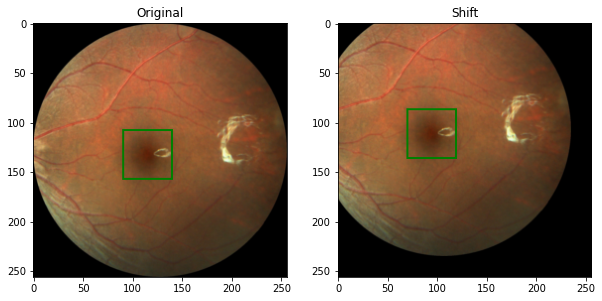

In [22]:
plt.figure(figsize=(10,10))

img, label = load_img_label(labels_df, id_)
print(img.size, label)

img_r, label_r = resize_img_label(img, label)
print(img_r.size, label_r)

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img_r,label_r, w_h=(50,50), thickness=2)


plt.subplot(1,2,2)
plt.title('Shift')
img_s, label_s = random_shift(img_r, label_r, max_translate=(.5,.5))
show_img_label(img_s,label_s)

### Custom Transformer

In [23]:
import random

In [24]:
def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image,label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image,label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image,label, params["max_translate"])
    image = TF.to_tensor(image)
    return image, label

In [25]:
params = {
    "target_size": (256,256),
    "p_hflip": 1.0,
    "p_vflip":1.0, 
    "p_shift":1.0,
    "max_translate": (0.2,0.2)
}

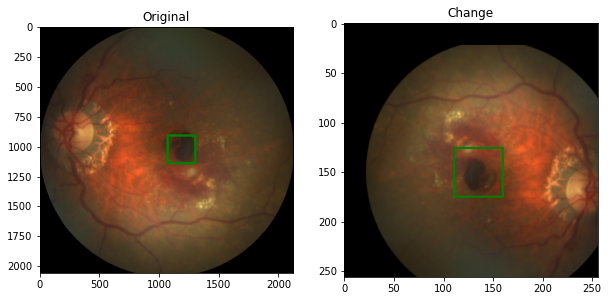

In [26]:
img, label = load_img_label(labels_df, 1)

img_t, label_t = transformer(img, label, params)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img,label, w_h=(250,250), thickness=20)
2
plt.subplot(1,2,2)
plt.title('Change')
show_img_label(TF.to_pil_image(img_t),label_t)

In [27]:
#Adding Brightness, contrast, gamma correction to prev transformer
# We also define scale label to limit them in (0,1)

def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

def transformer(image, label, params):
    image, label = resize_img_label(image, label, params["target_size"])
    if random.random() < params["p_hflip"]:
        image, label = random_hflip(image,label)
    if random.random() < params["p_vflip"]:
        image, label = random_vflip(image,label)
    if random.random() < params["p_shift"]:
        image, label = random_shift(image,label, params["max_translate"])
    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image = TF.adjust_brightness(image, brightness_factor)
    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image = TF.adjust_contrast(image, contrast_factor)
    if random.random() < params["p_gamma"]:
        gamma = 1+(np.random.rand()*2-1)*params["gamma"]
        image = TF.adjust_gamma(image, gamma)
    if params["scale_label"]:
        label = scale_label(label, params['target_size'])   
    
    image = TF.to_tensor(image)
    return image, label



In [28]:
params = {
    "target_size": (256,256),
    "p_hflip": 1.0,
    "p_vflip":1.0, 
    "p_shift":1.0,
    "max_translate": (0.2,0.2),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False
}

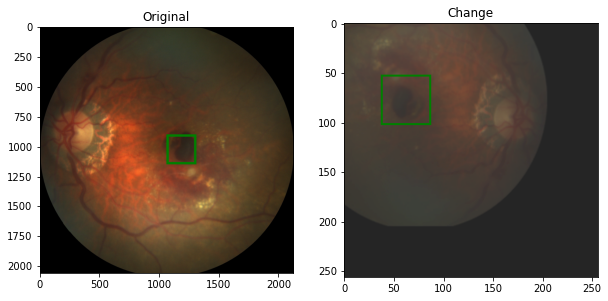

In [29]:
img, label = load_img_label(labels_df, 1)

img_t, label_t = transformer(img, label, params)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Original')
show_img_label(img,label, w_h=(250,250), thickness=20)
2
plt.subplot(1,2,2)
plt.title('Change')
show_img_label(TF.to_pil_image(img_t),label_t)

In [30]:
def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

### Creating Custom Dataset

In [31]:
from torch.utils.data import Dataset
from PIL import Image

In [32]:
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_param):
        path2label = "./Fovea_location.xlsx"
        labels_df = pd.read_excel(path2label)
        self.labels = labels_df[["Fovea_X", "Fovea_Y"]].values
        
        self.imgName = labels_df["imgName"]
        self.ids = labels_df.index
        
        self.fullPath2img = []
        
        for id_ in self.ids:
            if self.imgName[id_][0] == 'A':
                prefix = 'AMD'
            else:
                prefix = 'Non-AMD'
            
            self.fullPath2img.append(os.path.join(path2data, "Training400", prefix, self.imgName[id_]))
        
        self.transform = transform
        self.trans_params = trans_param
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        image = Image.open(self.fullPath2img[idx])
        label = self.labels[idx]
        image, label = self.transform(image, label, self.trans_params)
        
        return image, label
    
    
        

In [33]:
trans_params_train={
"target_size" : (256, 256),
"p_hflip" : 0.5,
"p_vflip" : 0.5,
"p_shift" : 0.5,
"max_translate": (0.2, 0.2),
"p_brightness": 0.5,
"brightness_factor": 0.2,
"p_contrast": 0.5,
"contrast_factor": 0.2,
"p_gamma": 0.5,
"gamma": 0.2,
"scale_label": True,
}

trans_params_val={
"target_size" : (256, 256),
"p_hflip" : 0.0,
"p_vflip" : 0.0,
"p_shift" : 0.0,
"p_brightness": 0.0,
"p_contrast": 0.0,
"p_gamma": 0.0,
"gamma": 0.0,
"scale_label": True,
}



In [34]:
amd_ds1 = AMD_dataset(path2data, transformer, trans_params_train)
amd_ds2 = AMD_dataset(path2data, transformer, trans_params_val)

In [35]:
for x, y in amd_ds1:
    print(x.shape)
    print(y)
    break

torch.Size([3, 256, 256])
[0.5566215996187523, 0.5029091237409825]


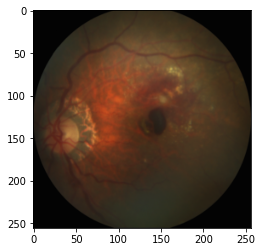

In [36]:
plt.imshow(x.numpy().transpose((1,2,0)))

In [37]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)

indices = range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

320
----------
80


In [38]:
from torch.utils.data import Subset
train_ds=Subset(amd_ds1,train_index)
print(len(train_ds))
val_ds=Subset(amd_ds2,val_index)
print(len(val_ds))

320
80


In [39]:
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label=rescale_label(label,img.shape[1:])
        x,y=label
        plt.plot(x,y,'b+',markersize=20)

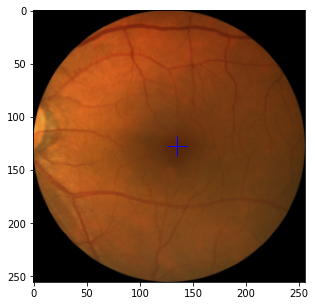

In [40]:
plt.figure(figsize=(5,5))
for img,label in train_ds:
    show(img,label)
    break

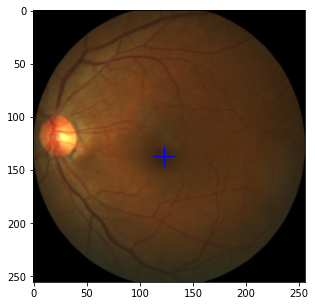

In [41]:
plt.figure(figsize=(5,5))
for img,label in val_ds:
    show(img,label)
    break

In [42]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size= 8, shuffle = True)

val_dl = DataLoader(val_ds, batch_size= 16, shuffle = False)

In [43]:
for x,y in train_dl:
    print(x.shape)
    print(y)
    break

torch.Size([8, 3, 256, 256])
[tensor([0.3652, 0.3468, 0.7184, 0.5519, 0.5222, 0.5163, 0.6469, 0.5627],
       dtype=torch.float64), tensor([0.4138, 0.4198, 0.6705, 0.4683, 0.4962, 0.5081, 0.6167, 0.5981],
       dtype=torch.float64)]


In [44]:
type(y)

list

In [45]:
# we need to convert this into torch format

for img_b, label_b in train_dl:
    #convert list to tensor
    label_b = torch.stack(label_b)
    label_b = label_b.type(torch.float32)
    print(label_b.shape, label_b.type)
    break

torch.Size([2, 8]) <built-in method type of Tensor object at 0x7fc97402ad38>


### Creating the Model

In [46]:
import torch.nn as nn
import torch.nn.functional as F

In [47]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_outputs = params["num_outputs"]
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, 
                               stride= 2, padding=1)
        self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3,
                              stride=1, padding=1)
        self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3,
                              padding=1)
        self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3,
                              padding=1)
        self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3,
                              padding=1)
        self.fc1 = nn.Linear(16*init_f, num_outputs)        
        
    def forward(self, x):
        
        identity = F.avg_pool2d(x,4,4)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = torch.cat((x, identity), dim= 1)
        
        identity = F.avg_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = torch.cat((x, identity), dim= 1)
        
        identity = F.avg_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = torch.cat((x, identity), dim= 1)
        
        identity = F.avg_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)
        x = torch.cat((x, identity), dim= 1)
        
        x = F.relu(self.conv5(x))
        x = F.adaptive_avg_pool2d(x,1)
        
        x = x.reshape(x.size(0),-1)
        
        x = self.fc1(x)
               
        
        return x

In [48]:
params = {
    "input_shape": (3,256,256),
    "initial_filters":16,
    "num_outputs": 2
}

model = Net(params)

In [49]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = 'cpu'

model = model.to(device)

In [50]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


## Defining the loss, optimizer, and IOU metric

In [51]:
loss_func = nn.SmoothL1Loss(reduction='sum')

In [52]:
from torch import optim
opt = optim.Adam(model.parameters(), lr = 3e-4)

In [53]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
current_lr = get_lr(opt)
print(current_lr)

0.0003


In [54]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode = 'min', factor = 0.5,
                                patience = 20, verbose= 1)

In [63]:
#convert coordinates to a bounding box

def cxcy2bbox(cxcy, w = 50./256, h= 50./256):
    w_tensor = torch.ones(cxcy.shape[0], 1, device = cxcy.device)*w
    h_tensor = torch.ones(cxcy.shape[0], 1, device = cxcy.device)*h
    cx = cxcy[:,0].unsqueeze(1)
    cy = cxcy[:,1].unsqueeze(1)
    
    boxes = torch.cat((cx,cy,w_tensor, h_tensor), -1) 
    
    return torch.cat((boxes[:,:2] - boxes[:,2:]/2,
                      boxes[:,:2] + boxes[:,2:]/2), 1)
    

In [67]:
torch.manual_seed(0)
cxcy=torch.rand(1,2)
print("center:", cxcy*256)
bb=cxcy2bbox(cxcy)
print("bounding box", bb*256)

center: tensor([[127.0417, 196.6648]])
bounding box tensor([[102.0417, 171.6648, 152.0417, 221.6648]])


In [81]:
import torchvision
# IOU_metric
def metrics_batch(output, target):
    output = cxcy2bbox(output)
    target = cxcy2bbox(target)
    
    iou = torchvision.ops.box_iou(output, target)
    
    return torch.diagonal(iou, 0).sum().item()
    

In [82]:
def loss_batch(loss_func, output, target, opt = None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [84]:
for xb,label_b in train_dl:
    label_b = torch.stack(label_b, 1).type(torch.float32).to(device)
    
    l,m = loss_batch(loss_func, label_b, label_b)
    print(l,m)
    break

0.0 8.0


In [91]:
from tqdm import tqdm

In [92]:
def loss_epoch(model, loss_func,dataset_dl,sanity_check = False, opt = None):
    running_loss = 0.0
    running_metric = 0.0
    
    len_data = len(dataset_dl.dataset)
    
    for xb,yb in tqdm(dataset_dl):
        yb = torch.stack(yb,1)
        yb = yb.type(torch.float32).to(device)
        output = model(xb.to(device))
        loss_b, metric_b = loss_batch(loss_func, output, yb,opt)
        running_loss+= loss_b
        running_metric += metric_b
        
        
    loss = running_loss/float(len_data)
    metric = running_metric/float(len_data)
    
    
    return loss, metric


In [93]:
import copy

def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]
    
    
    loss_history = {
        "train": [],
        "val": []
        }
    metric_history = {
        "train": [],
        "val": []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print(f'Epoch {epoch+1}/{num_epochs}, current_lr = {current_lr}')
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl,
                                             sanity_check, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl,
                                             sanity_check, opt = None)
            loss_history["val"].append(val_loss)
            metric_history["val"].append(val_metric)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Model saved")
            
        lr_scheduler.step()
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
            
        print("train loss: %.6f, accuracy: %.2f"%(train_loss,100*train_metric))
        print("val loss: %.6f, accuracy: %.2f"%(val_loss,100*val_metric))
        print("-"*10)
        
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history
    

In [94]:
loss_func = nn.SmoothL1Loss(reduction='sum')
opt = optim.Adam(model.parameters(), lr = 1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode = 'min', factor=0.5, patience= 20, verbose =1 )

path2models = "./"

params_train={
"num_epochs": 100,
"optimizer": opt,
"loss_func": loss_func,
"train_dl": train_dl,
"val_dl": val_dl,
"sanity_check": False,
"lr_scheduler": lr_scheduler,
"path2weights": path2models+"weights_smoothl1.pt",
}
model,loss_hist,metric_hist=train_val(model,params_train)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/100, current_lr = 0.0001


 25%|██▌       | 10/40 [00:10<00:30,  1.02s/it]


KeyboardInterrupt: 

False